In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.optimize import curve_fit
import matplotlib as mpl
from PIL import ImageColor
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ks_2samp, gaussian_kde
from scipy import interpolate

import pandas as pd 
import matplotlib.patches as mpatches


label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
markers = ['o','>','s','d','+','*','<']

In [25]:
#CDF : Cumulative Distribution Function
def CDF(X):
    X = np.sort(X)
    Y = np.arange(1,len(X)+1)/len(X)
    return(X,Y)

In [26]:
def load_cellpose_masks(npyfilepath,display=False):
    seg = np.load(npyfilepath,allow_pickle=True)
    M = seg.all()['masks']
    O = seg.all()['outlines']
    if display == True :
        fig,ax = plt.subplots(ncols=2,figsize=(8,4),sharey=True)
        ax[0].matshow(M,cmap='viridis')
        ax[1].matshow(O,cmap='viridis')
        return(M,O)
    else:
        return(M,O)

Demonstration of the function ```load_cellpose_masks()```

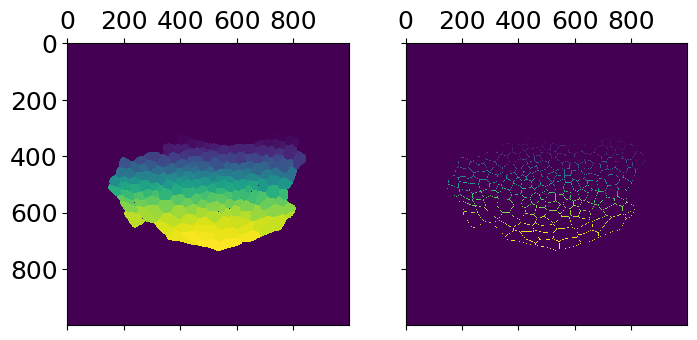

In [27]:
M,O = load_cellpose_masks('sample_cellpose_seg.npy',True)

#### Measures of roundness/cell shape

In [28]:
'''
Computes the ratio of the cell area to the area of the circle whose diameter is equal to the length of the longest 
diagonal of the polygon (cell outline). As the cell shape approaches that of a circle the value approaches 1
'''

def compute_roundness(Outlines,Masks):
    Round_Mat = np.zeros(Outlines.shape)
    O_ = np.ones(Outlines.shape)
    O_[O > 0] = 0
    n_cells = np.max(Masks)+1
    Roundness_Values = np.zeros(n_cells)
    for i in range(1,n_cells):
        BI = (Masks == i)
        Z = BI*(Outlines==i)
        y,x = np.nonzero(Z)
        pos = np.array([x,y]).T
        diameter = np.max(pdist(pos,metric='euclidean'))
        Circle_area = np.pi * diameter * diameter * 0.25
        Cell_area = np.sum(BI)
        roundness = Cell_area/Circle_area
        Roundness_Values[i] = roundness
        Round_Mat[BI] = roundness
        Round_Mat *= O_
    return(Round_Mat,Roundness_Values)

'''
Computes the ratio of square root of the area of a cell to the perimeter of the cell 
- area is the total number of pixels belonging to a cell
- perimeter is the number of pixels that are at the boundary of the cell
'''
def compute_peri_by_area(Outlines,Masks):
    PeriArea = np.zeros(Outlines.shape)
    O_ = np.ones(Outlines.shape)
    O_[O > 0] = 0
    n_cells = np.max(Masks)+1
    peri_area_values = np.zeros(n_cells)
    
    for i in range(1,n_cells):
        BI = (Masks == i)
        Area = np.sum(BI)
        Peri = np.sum(Outlines == i)
        PeriArea[BI] = np.sqrt(Area)/Peri
        peri_area_values[i] = np.sqrt(Area)/Peri
        PeriArea *= O_
    return(PeriArea,peri_area_values)


def display_tissue_with_roundness_values(npyfilepath,measure_type=1):
    M,O = load_cellpose_masks('sample_cellpose_seg.npy',False)
    if measure_type == 1:
        RM,RV = compute_roundness(O,M)
    elif measure_type == 2:
        RM,RV = compute_peri_by_area(O,M)
    else:
        print('measure type undefined!')
        return None
        
    #--- compute bounds of the image-----#
    x_ = np.sum(M[1:-1,1:-1],axis=0)
    y_ = np.sum(M[1:-1,1:-1],axis=1)
    
    
    x_min = np.min(np.nonzero(x_ > 0)[0])-2
    x_max = np.max(np.nonzero(x_ > 0)[0])+2
    y_min = np.min(np.nonzero(y_ > 0)[0])-2
    y_max = np.max(np.nonzero(y_ > 0)[0])+2
    #--------------------------------------#
    w = 8
    h = ((y_max-y_min)/(x_max-x_min))* w
    
    fig,ax = plt.subplots(figsize=(w,h))
    im = ax.imshow(RM[y_min:y_max,x_min:x_max],cmap='magma')
    cb = fig.colorbar(im)
    cb.set_label('roundness',fontsize=14)
    plt.show()
        

Demonstration of the function ```display_tissue_with_roundness_values()``` which calls
```compute_roundness()``` or ```compute_peri_by_area()``` internally


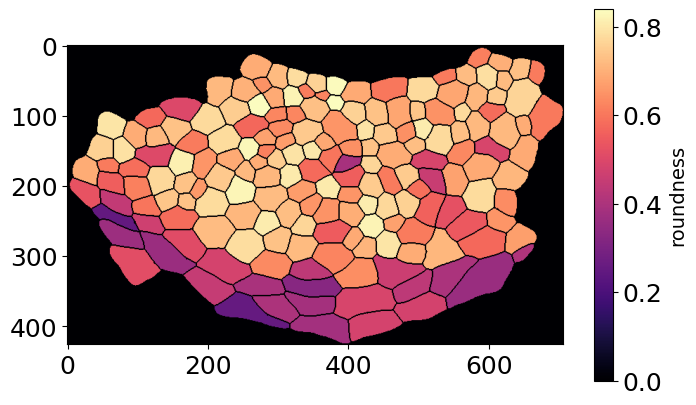

In [29]:
display_tissue_with_roundness_values('sample_cellpose_seg.npy',1)

Plotting the cumulative distribution of the roundness values using ```CDF()``` function

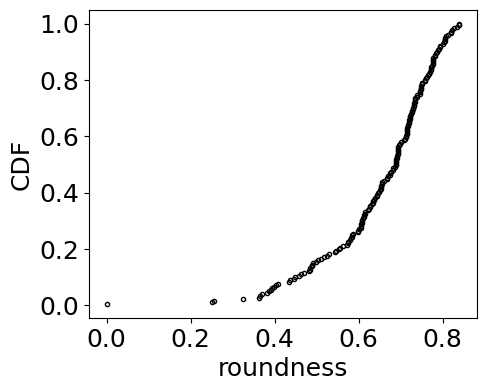

In [30]:
M,O = load_cellpose_masks('sample_cellpose_seg.npy',False)
RM,RV = compute_roundness(O,M)

X,Y = CDF(RV)
fig,ax = plt.subplots(figsize=(5,4))
ax.plot(X,Y,'.',color='k',markerfacecolor='none')
ax.set_xlabel('roundness',fontsize=18)
ax.set_ylabel('CDF',fontsize=18)
plt.show()

## Making figures

Plotting the division angles at four time blocks 32hpf, 38hpf, 44hpf and 50hpf 

In [31]:
def plot_empirical_division_angles():
    S = open('20250304_OCD_PLOT.csv','r').read()
    S = S.replace('IL-P','IL').replace('IL-A','IL')
    f = open('tmp.csv','w')
    f.write(S)
    f.close()
    
    df = pd.read_csv('tmp.csv')
    
    Stages = [32,38,44,50]
    
    Groups = ['A','P','IL'] 
    
    BSCols = ['#737373','#a1d76a','#e9a3c9']
    
    patch_3 = mpatches.Patch(color=BSCols[0], label='IL')
    patch_2 = mpatches.Patch(color=BSCols[1], label='P')
    patch_1 = mpatches.Patch(color=BSCols[2], label='A')
    
    BINS = np.linspace(0,np.pi/2,11)
    
    fig, ax = plt.subplots(ncols=4,subplot_kw=dict(projection='polar'),figsize=(16,4))
    
    Data = []
    
    for j in range(4):
        stage = Stages[j]
        df_ = df[df.STAGE == stage] 
        All = np.array(df_.DEG_IL_CORR) * (np.pi/180)
    
        A = np.array(df_[df_.REGION == 'A'].DEG_IL_CORR) * (np.pi/180)
        B = np.array(df_[df_.REGION == 'P'].DEG_IL_CORR) * (np.pi/180)
        C = np.array(df_[df_.REGION == 'IL'].DEG_IL_CORR) * (np.pi/180)
    
        
        All = np.pi/2 - np.abs((np.pi/2 - All))
    
        A = np.pi/2 - np.abs((np.pi/2 - A))
        B = np.pi/2 - np.abs((np.pi/2 - B))
        C = np.pi/2 - np.abs((np.pi/2 - C))
        
        Y0,X = np.histogram(All,bins=BINS,density=True)
        
    
        X = 0.5 *(X[:-1] + X[1:])
        Y1,_ = np.histogram(A,bins=BINS,density=False)
        Y2,_ = np.histogram(B,bins=BINS,density=False)
        Y3,_ = np.histogram(C,bins=BINS,density=False)
    
       
    
        Y2 += Y1 
        Y3 += Y2
        
        denom = Y3[0]/Y0[0] 
    
        Y1 = Y1/denom 
        Y2 = Y2/denom
        Y3 = Y3/denom 
       
        Data.append([Y3,Y2,Y1])
    
    
    w = 0.9*(X[1] - X[0])
    
    Labs = ['32hpf','38hpf','44hpf','50hpf']
    
    
    for i in range(4):
        bars_3 = ax[i].bar(X,Data[i][0],width = 0.7*w,color=BSCols[0],edgecolor='None') ;
        bars_2 = ax[i].bar(X,Data[i][1],width = 0.7*w,color=BSCols[1],edgecolor='None') ;
        bars_1 = ax[i].bar(X,Data[i][2],width = 0.7*w,color=BSCols[2],edgecolor='None') ;
    
        ax[i].set_thetamin(0)
        ax[i].set_thetamax(90)
        ax[i].set_xticks(np.array([0,30,60,90])*(np.pi/180))
        ax[i].set_rticks([0,0.4,0.8])
        ax[i].set_rlim(0,1.05)
        ax[i].text(85*(np.pi/180),1.25,Labs[i],fontsize=20)
        ax[i].text(330*(np.pi/180),0.5,r'$p_{div}$',fontsize=18)
    
    plt.legend(handles=[patch_1,patch_2,patch_3],loc='best', bbox_to_anchor=(1, 1.1),ncol=1)
    
    plt.show()
    return(None)


Usage of ```plot_empirical_division_angles()```

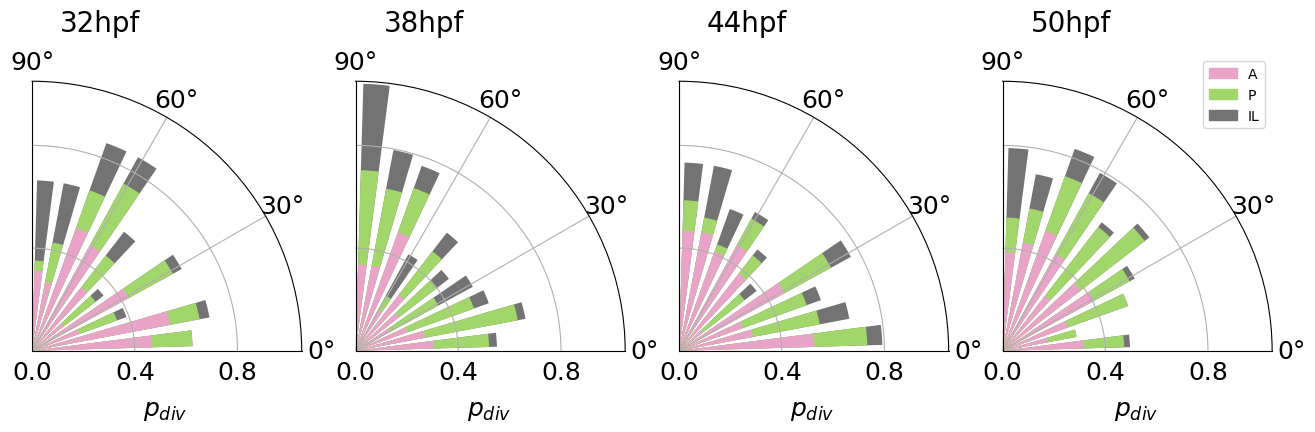

In [32]:
plot_empirical_division_angles()

Figures realted midline ablation study 

In [33]:
def compute_selectcells_roundness(Outlines,Masks,CID):
    Round_Mat = np.zeros(Outlines.shape)
    
    n_cells = len(CID)
    Roundness_Values = np.zeros(n_cells)
    for i in range(n_cells):
        cid = CID[i]
        BI = (Masks == cid)
        Z = BI*(Outlines==cid)
        y,x = np.nonzero(Z)
        pos = np.array([x,y]).T
        diameter = np.max(pdist(pos,metric='euclidean'))
        Circle_area = np.pi * diameter * diameter * 0.25
        Cell_area = np.sum(BI)
        roundness = Cell_area/Circle_area
        Roundness_Values[i] = roundness 
    return(Roundness_Values)

def compute_roundness_nearest_cells(filename,sp_cid,howmany=200):
    seg = np.load(filename,allow_pickle=True)
    M = seg.all()['masks']
    O = seg.all()['outlines']
    n_cells = np.max(M) + 1
    Centroids = np.zeros((n_cells,2))
    for i in range(1,n_cells):
        ii,jj = np.nonzero(M == i)
        Centroids[i,:] = np.mean(jj),np.mean(ii)
    spc_x,spc_y = Centroids[sp_cid,:]
    IDX = np.nonzero(Centroids[:,1] >= spc_y)[0]
    Centroids_ = Centroids[IDX,:]
    D = (Centroids_[:,0] - spc_x)**2 + (Centroids_[:,1] - spc_y)**2
    idx_ = np.argsort(D)
    CID = IDX[idx_[:howmany]]
    Roundness_Values = compute_selectcells_roundness(O,M,CID)
    return(Roundness_Values,CID)

def compute_roundness_nearest_cells_two_halves(filename,sp_cid,ab_side,howmany=100):
    seg = np.load(filename,allow_pickle=True)
    M = seg.all()['masks']
    O = seg.all()['outlines']
    n_cells = np.max(M) + 1
    Centroids = np.zeros((n_cells,2))
    for i in range(1,n_cells):
        ii,jj = np.nonzero(M == i)
        Centroids[i,:] = np.mean(jj),np.mean(ii)
    spc_x,spc_y = Centroids[sp_cid,:]
    IDX_left  = np.nonzero((Centroids[:,1] >= spc_y)  * (Centroids[:,0] <= spc_x))[0]
    IDX_right = np.nonzero((Centroids[:,1] >= spc_y)  * (Centroids[:,0] > spc_x))[0]

    
    Centroids_L = Centroids[IDX_left,:]
    Centroids_R = Centroids[IDX_right,:]

    
    D_L = (Centroids_L[:,0] - spc_x)**2 + (Centroids_L[:,1] - spc_y)**2
    D_R = (Centroids_R[:,0] - spc_x)**2 + (Centroids_R[:,1] - spc_y)**2
    
    idx_left  = np.argsort(D_L)
    idx_right = np.argsort(D_R)
    
    CID_L = IDX_left[idx_left[:howmany]]
    CID_R = IDX_right[idx_right[:howmany]]

    RV_L,RV_R = compute_selectcells_roundness(O,M,CID_L),compute_selectcells_roundness(O,M,CID_R)

    if ab_side == 0:
        return(RV_L,RV_R,CID_L,CID_R)
    elif ab_side == 1:
        return(RV_R,RV_L,CID_R,CID_L)

def st_line(x,m,c):
    y = m*x + c
    return(y)


def fit_kde(X):
    kde = gaussian_kde(X)
    x_values = np.linspace(0, 1, 1000)
    kde_values = kde(x_values)
    return(x_values,kde_values)


def fit_CDF(A):
    X = np.sort(A)
    Y = np.arange(1,len(A)+1)/len(A)
    f = interpolate.interp1d(X, Y, fill_value='extrapolate')
    x_fit = np.linspace(0.2,0.9,10000)
    y_fit = f(x_fit)
    y_fit[y_fit > 1] = 1
    y_fit[y_fit < 0] = 0

    
    return(x_fit,y_fit)


Loading data related to roundness values of different subset of cells computed using functions defined above

In [34]:
Colors = ['#000000','#008080','#b03060','#0000ff','#ff1493','#ffa500']
COLORS = [ImageColor.getcolor(ele, "RGB") for ele in Colors]

DataDict = dict(np.load('Roundness_Values_Dict.npz',allow_pickle=True))

Keys = ['RV_WT','RV_Ctrl_Ab','RV_Ctrl_Nb','RV_Exp_Ab','RV_Exp_Nb']

Labels = ['WT','Lat-UA','Lat-A','Mid-UA','Mid-A']

Data = [DataDict['RV_WT'],DataDict['RV_Ctrl_Nb'],DataDict['RV_Ctrl_Ab'],DataDict['RV_Exp_Nb'],DataDict['RV_Exp_Ab']]

Roundness values of the 5 different groups

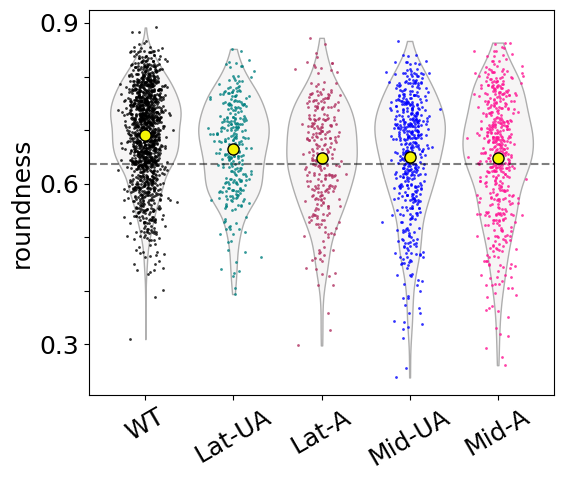

In [35]:
fig,ax = plt.subplots(figsize=(6,5))
ax.set_yticks([0.3,0.6,0.9])
plots = ax.violinplot(Data,showextrema=False,showmeans=False,widths=0.8)
for pc in plots['bodies'] :
    pc.set_facecolor('#e2dfdf')
    pc.set_edgecolor('k')
for j in range(5):
    y_ = Data[j]
    x_ = np.random.normal(j+1,0.1,len(y_))
    ax.plot(x_,y_,'.',color=Colors[j],markerfacecolor='None',alpha=0.8,markersize=2)
    ax.plot(j+1,np.mean(Data[j]),'o',color='#f4f405',markersize=8,markeredgecolor='k')
ax.axhline(0.6366,linestyle='--',color='k',alpha=0.5)
ax.set_yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax.set_yticklabels(['0.3','','','0.6','','','0.9'])
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(Labels,rotation=30)
ax.set_ylabel('roundness',fontsize=18)
#plt.savefig('Fig5b.svg',bbox_inches='tight')
plt.show()


Difference in PDF(roudness) compared to WT

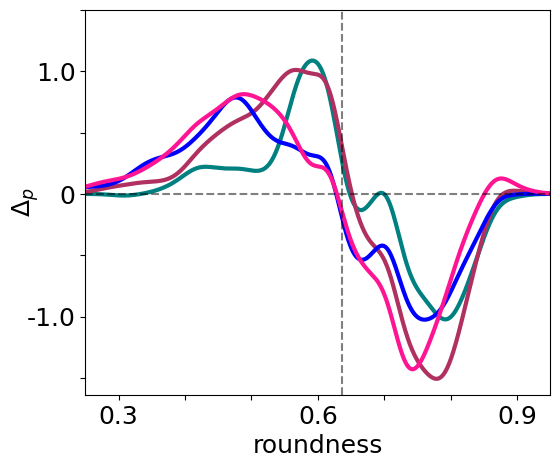

In [36]:
px1,py1 = fit_kde(Data[0])

px2,py2 = fit_kde(Data[1])
px3,py3 = fit_kde(Data[2])
px4,py4 = fit_kde(Data[3])
px5,py5 = fit_kde(Data[4])

fig,ax = plt.subplots(figsize=(6,5))
ax.plot(px2,py2-py1,color=Colors[1],label=Labels[1],lw=3)
ax.plot(px3,py3-py1,color=Colors[2],label=Labels[2],lw=3)
ax.plot(px4,py4-py1,color=Colors[3],label=Labels[3],lw=3)
ax.plot(px5,py5-py1,color=Colors[4],label=Labels[4],lw=3)
ax.set_xlim(0.25,0.95)
ax.set_xticks([0.3,0.6,0.9])
ax.set_yticks([-1,0,1])
ax.set_ylabel('$\Delta_p$',fontsize=18,labelpad=-10)
#ax.legend(loc='best',fontsize=14,ncol=2)
ax.set_yticks([-1.5,-1.0,-0.5,0,0.5,1.0,1.5])
ax.set_yticklabels(['','-1.0','','0','','1.0',''])
ax.set_xticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax.set_xticklabels(['0.3','','','0.6','','','0.9'])
ax.axvline(0.6366,linestyle='--',color='k',alpha=0.5)
ax.axhline(0.0,linestyle='--',color='k',alpha=0.5)
ax.set_xlabel('roundness',fontsize=18)
#plt.savefig('Fig5b_prime.svg',bbox_inches='tight')
plt.show()


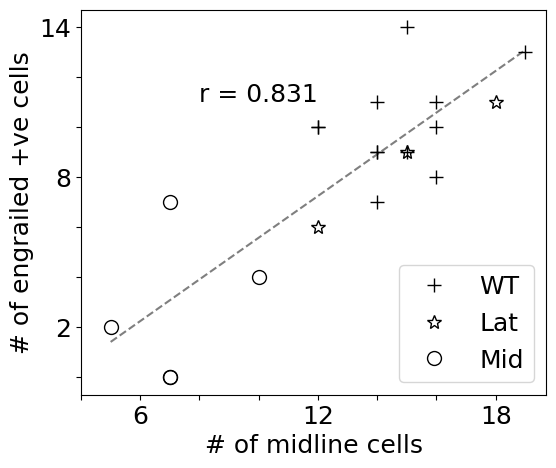

In [37]:
fig,ax = plt.subplots(figsize=(6,5))
df = pd.read_csv('MIDLINE_ABL_RESULTS.csv')
TMC = np.array(df.Total_mid_cells)
ENC = np.array(df.Eng_total)
popt,_ = curve_fit(st_line,TMC,ENC)
m,c  = popt 
x_fit = np.linspace(np.min(TMC),np.max(TMC),1000)
y_fit = st_line(x_fit,m,c)

r_cor = np.round(np.corrcoef(TMC,ENC)[0,1],3)

#0-4 Exp 5-7 Cntrl 8-19 WT
ax.plot(TMC[8:],ENC[8:],'+',color='k',markerfacecolor='None',markersize=10,label='WT')
ax.plot(TMC[5:8],ENC[5:8],'*',color='k',markersize=10,markerfacecolor='None',label='Lat')
ax.plot(TMC[0:5],ENC[0:5],'o',color='k',markersize=10,markerfacecolor='None',label='Mid')

ax.plot(x_fit,y_fit,linestyle='--',color='k',alpha=0.5)

ax.text(8,11,'r = '+str(r_cor),fontsize=18)

ax.set_xticks([4,6,8,10,12,14,16,18])
ax.set_xticklabels(['','6','','','12','','','18'])

ax.set_yticks([0,2,4,6,8,10,12,14])
ax.set_yticklabels(['','2','','','8','','','14'])

ax.legend(loc=4,fontsize=18)
ax.set_xlabel('# of midline cells',fontsize=18)
ax.set_ylabel('# of engrailed +ve cells',fontsize=18)
#plt.savefig('Fig5c_prime.svg',bbox_inches='tight')
plt.show()


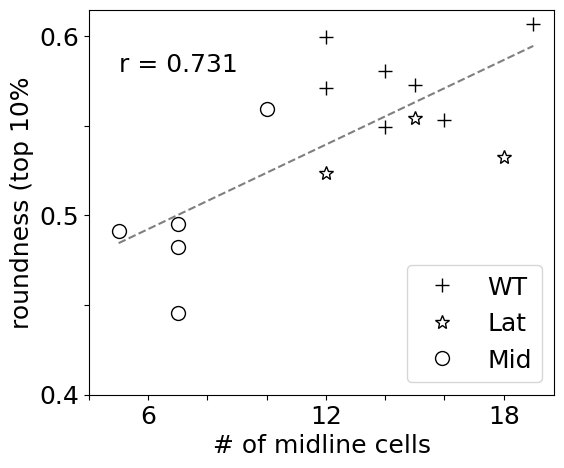

In [38]:
ptile = 10 # 10 percentile 
#7-3-5
TMC_subset = [15,19,16,14,12,14,12,15,18,12,7,7,5,10,7]
RV_Ind = np.load('RV_Ind_Tissues.npy')
RV_ptile = [np.percentile(RV_Ind[i,:],ptile) for i in range(15)]

popt,_ = curve_fit(st_line,TMC_subset,RV_ptile)
m,c  = popt 
x_fit = np.linspace(np.min(TMC_subset),np.max(TMC_subset),1000)
y_fit = st_line(x_fit,m,c)
r_cor = np.round(np.corrcoef(TMC_subset,RV_ptile)[0,1],3)

fig,ax = plt.subplots(figsize=(6,5))
ax.plot(TMC_subset[:7],RV_ptile[:7],'+',color='k',markerfacecolor='None',markersize=10,label='WT')
ax.plot(TMC_subset[7:10],RV_ptile[7:10],'*',color='k',markersize=10,label='Lat',markerfacecolor='None')
ax.plot(TMC_subset[10:],RV_ptile[10:],'o',color='k',markersize=10,label='Mid',markerfacecolor='None')
ax.plot(x_fit,y_fit,'--',color='k',alpha=0.5)
ax.text(5,0.58,'r = '+str(r_cor),fontsize=18)
ax.legend(loc=4,fontsize=18)
ax.set_yticks([0.4,0.45,0.5,0.55,0.6])
ax.set_yticklabels(['0.4','','0.5','','0.6'])
ax.set_xticks([4,6,8,10,12,14,16,18])
ax.set_xticklabels(['','6','','','12','','','18'])
#plt.savefig('Fig5c.svg',bbox_inches='tight')
ax.set_xlabel('# of midline cells',fontsize=18)
ax.set_ylabel('roundness (top 10%',fontsize=18)
plt.show()